In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import re
import glob



In [ ]:
activity_data = np.load("./Activity Index/activity_list_full_flock_bbox_radius.npy")

In [ ]:
plt.plot(activity_data)
plt.show()

In [89]:
input_21Sep=pd.read_csv("data/21Sep_summary.csv",header=2,dayfirst=True) #ASK109

Reduce original data to only necessary columns: 

In [90]:
input_21Sep = input_21Sep[["O/B's","Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 11","Unnamed: 18"]]
input_21Sep.columns = ["Date","Mortality Rate", "Mortality", "Guideline Average Shed Temperature", "Water Usage(L)", "Feed Usage(grms/bird)"]
# input_21Sep.Date = input_21Sep.Date.astype('datetime64[ns]')
input_21Sep.Date = pd.to_datetime(input_21Sep.Date, dayfirst=True)
input_21Sep.head()

,Date,Mortality Rate,Mortality,Guideline Average Shed Temperature,Water Usage(L),Feed Usage(grms/bird)
0,2020-09-21,0.00%,0,33.0,0,NaN
1,2020-09-22,0.13%,16,32.4,14,NaN
2,2020-09-23,0.16%,36,31.8,19,NaN
3,2020-09-24,0.25%,68,31.2,29,2
4,2020-09-25,0.03%,72,30.8,39,NaN


Water and feed usage are low in the first few days because farmers would ditribute them on the ground all over the shed.

In [4]:
df0 = pd.read_csv("data/HumidTemp/mench-siteb-house2 03.csv")

df0['Timestamp']= pd.to_datetime(df0['Timestamp'])
df0=df0.rename(columns = {'Timestamp':'Timestamp'+re.findall(r'\d\d',"data/HumidTemp/mench-siteb-house2 03.csv")[0]})

for i in glob.glob('data/HumidTemp/*.csv')[1:]:
    df1 = pd.read_csv(i)
    
    df1['Timestamp']= pd.to_datetime(df1['Timestamp'])
    
    prev_filename = glob.glob('data/HumidTemp/*.csv')[glob.glob('data/HumidTemp/*.csv').index(i)-1]
    
    if df0['Timestamp'+re.findall(r'\d\d',prev_filename)[0]].min() <= df1['Timestamp'].min():
        dftimestamp_later = df1['Timestamp'].min()
        df0 = df0[df0['Timestamp'+re.findall(r'\d\d',prev_filename)[0]]>=dftimestamp_later].reset_index(drop=True)

    else:
        dftimestamp_later = df0['Timestamp'+re.findall(r'\d\d',prev_filename)[0]].min()
        df1 = df1[df1["Timestamp"]>=dftimestamp_later].reset_index(drop=True)

    df_fin = pd.concat((df0,df1),axis=1)
    df_fin=df_fin.rename(columns = {'Timestamp':'Timestamp'+re.findall(r'\d\d',i)[0]})

    df0=df_fin
    

df_fin.head()


,Timestamp03,Temperature (°C),Relative Humidity (%),Timestamp05,Temperature (°C),Relative Humidity (%),Timestamp06,Temperature (°C),Relative Humidity (%),Timestamp07,...,Relative Humidity (%),Timestamp15,Temperature (°C),Relative Humidity (%),Timestamp16,Temperature (°C),Relative Humidity (%),Timestamp18,Temperature (°C),Relative Humidity (%)
0,2020-10-03 14:44:00,24.5667,73.68,2020-10-03 14:44:00,17.8889,73.74,2020-10-03 14:44:00,26.8611,78.59,2020-10-03 14:44:00,...,69.26,2020-10-03 14:44:00,24.8167,67.61,2020-10-03 14:44:00,24.6111,67.43,2020-10-03 14:44:00,23.9333,69.90
1,2020-10-03 14:45:00,24.6444,73.22,2020-10-03 14:45:00,17.9000,73.71,2020-10-03 14:45:00,26.9389,74.51,2020-10-03 14:45:00,...,69.47,2020-10-03 14:45:00,24.7944,66.81,2020-10-03 14:45:00,24.6222,67.49,2020-10-03 14:45:00,23.9778,69.96
2,2020-10-03 14:46:00,24.6944,72.43,2020-10-03 14:46:00,17.9056,73.68,2020-10-03 14:46:00,27.7833,73.86,2020-10-03 14:46:00,...,69.20,2020-10-03 14:46:00,24.7833,67.12,2020-10-03 14:46:00,24.6333,67.30,2020-10-03 14:46:00,24.0222,69.78
3,2020-10-03 14:47:00,24.7167,72.16,2020-10-03 14:47:00,17.9056,73.68,2020-10-03 14:47:00,28.3889,66.78,2020-10-03 14:47:00,...,69.29,2020-10-03 14:47:00,24.7722,67.27,2020-10-03 14:47:00,24.6444,67.55,2020-10-03 14:47:00,24.0556,70.42
4,2020-10-03 14:48:00,24.7722,73.07,2020-10-03 14:48:00,17.9167,73.62,2020-10-03 14:48:00,28.3889,65.23,2020-10-03 14:48:00,...,69.62,2020-10-03 14:48:00,24.7500,67.33,2020-10-03 14:48:00,24.6667,67.70,2020-10-03 14:48:00,24.1389,69.96


In [5]:
df_fin_copy = df_fin
# df_fin = df_fin_copy

In [6]:
df_fin_time = df_fin.iloc[:, 0] 

df_fin = df_fin.drop((df_fin.filter(regex='Timestamp')).columns, axis = 1)

df_fin.insert(0, column='Timestamp', value=df_fin_time)

Sensor 06 (third column) has the last day data missing

In [7]:
#calc average , min, max, med temp
# reduced to only 8 entries temp&hum per day
df_daily = df_fin.resample('D', on='Timestamp').mean().reset_index()

import statistics

column_names = ['Average Temperature','Median Temperature','Min Temperature','Max Temperature',
               'Average Humidity','Median Humidity','Min Humidity','Max Humidity']
regex_for_original = ['Temperature','Temperature','Temperature','Temperature',
                      'Humidity','Humidity','Humidity','Humidity']
operations = [statistics.mean, statistics.median,min,max,statistics.mean, statistics.median,min,max]
for i,j,k in zip(column_names,regex_for_original,operations):
    df_daily.insert(1, column=i, 
                      value=pd.DataFrame(df_daily.filter(regex=j).values).apply(k, axis =1))

df_daily = df_daily.loc[:, :'Average Temperature']

In [130]:
# idea is to visualise how the temp and humid are changing throughout the day, taking into account spatial view

# df_spatial = df_fin.resample('D', on='Timestamp').mean().reset_index()

# column_names = ['Average Temperature','Median Temperature','Min Temperature','Max Temperature',
#                'Average Humidity','Median Humidity','Min Humidity','Max Humidity']
# regex_for_original = ['Temperature','Temperature','Temperature','Temperature',
#                       'Humidity','Humidity','Humidity','Humidity']
# operations = [statistics.mean, statistics.median,min,max,statistics.mean, statistics.median,min,max]
# for i,j,k in zip(column_names,regex_for_original,operations):
#     df_spatial.insert(1, column=i, value=pd.DataFrame(df_spatial.filter(regex=j).values).apply(k, axis =0))

# df_spatial = df_spatial.loc[:, :'Average Temperature']

<AxesSubplot:>

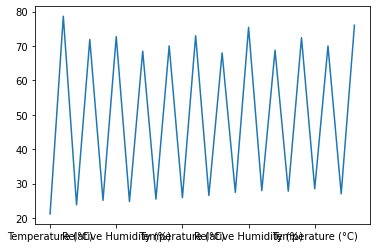

In [115]:
# df_fin.resample('D', on='Timestamp').mean().reset_index().iloc[1].drop("Timestamp").plot()

Now we have daily temp and humid range
Now aggregate the guideline temp with actual ones: 

FLOCK 1: 21/09/20 - 20/11/20

In [92]:
f1 = df_daily.loc[(df_daily["Timestamp"]>="2020-09-21") & (df_daily["Timestamp"]<="2020-11-20")][['Timestamp','Average Temperature']]
f1_temp = pd.merge(input_21Sep[["Date","Guideline Average Shed Temperature"]], f1, left_on="Date", right_on="Timestamp", how = "left").drop("Timestamp",axis=1)

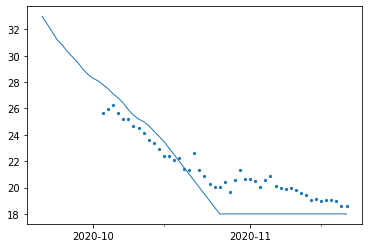

In [145]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# ax.tick_params(pad=10)

ax.xaxis.set_major_locator((mdates.MonthLocator()))
ax.xaxis.set_minor_locator((mdates.MonthLocator(bymonthday=15)))


plt.plot(f1_temp.Date, f1_temp['Guideline Average Shed Temperature'], linewidth=1)
plt.scatter(f1_temp.Date, f1_temp['Average Temperature'], s = 5)
plt.show() 

Actual temperature varies from guideline, where (15-10-2020, 24 days ) the actual temp is higher than guideline. 

earlier half is lower than guideline, later half hotter. 

In [ ]:
data_collection = pd.read_csv("data collection sheets/Data collection_ Menchine site B shed 2, 2020-07-20 - 2020-09-09 - Exp 1.csv",
                             skiprows=[0,1,2])

In [ ]:
data_collection2.head()

In [ ]:
# plt.scatter(data_collection[data_collection["Chicken (e.g. #1)"] == "#1"]["Date"],
#          data_collection[data_collection["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"])
data_collection[data_collection["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"].plot()

plt.title("Chicken weight during 2020-07-20 - 2020-09-09, 49 days in total")
# data_collection[data_collection["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"].shape

In [ ]:
data_collection2 = pd.read_csv("data collection sheets/Data collection_ Menchine site B shed 2, 2020-09-21 - 2020-11-09 - Exp 1.csv",
                             skiprows=[0,1,2])

In [ ]:
data_collection2[data_collection2["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"].plot()

plt.title("Chicken weight during 2020-09-21 - 2020-11-09, 42 days in total")
# data_collection2[data_collection2["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"].shape

In [ ]:
data_collection3 = pd.read_csv("data collection sheets/Data Collection_ Menchine site B shed 2, 2020-11-26 - 2021-01-20 - Exp 1.csv",
                             skiprows=[0,1,2])

In [ ]:
data_collection3[data_collection3["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"].plot()

plt.title("Chicken weight during 2020-11-26 - 2021-01-20, 10 data in total")
data_collection3[data_collection3["Chicken (e.g. #1)"] == "#1"]["Farm scale weight"].shape

In [ ]:
# dweights = pd.read_csv("weight recordings/weights id0 2020-08-04 09/58/17.586819.csv")
#                              skiprows=[0,1,2])
dweights = pd.read_csv("weight recordings/w.csv")



In [ ]:
dweights["0.61"].plot.kde()
plt.title("weight distribution on 2020-08-04")

In [ ]:
summary09 = pd.read_csv("humidity & temperature/mench-siteb-house2 09.csv")
summary10 = pd.read_csv("humidity & temperature/mench-siteb-house2 10.csv")

In [ ]:
summary09.iloc[::30, :]["Temperature (°C)"].plot()
plt.title("Sensor 9 temperature readings 2021-01-01 - 2021-01-20")
plt.show()
summary09.iloc[::30, :]["Relative Humidity (%)"].plot()
plt.title("Sensor 9 humidity readings 2021-01-01 - 2021-01-20")

In [ ]:
summary10.iloc[::30, :]["Temperature (°C)"].plot() # every 30 min
plt.title("Sensor 10 temperature readings 2021-01-01 - 2021-01-20")
plt.show()
summary10.iloc[::30, :]["Relative Humidity (%)"].plot()
plt.title("Sensor 10 humidity readings 2021-01-01 - 2021-01-20")